# Document AI: Fine-tuning LayoutLM for document-understanding using Hugging Face Transformers



## 1. Setup Development Environment


In [1]:
# python
!pip install pytesseract transformers datasets seqeval tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=dc2275ff4d4d079a9c9936bb5e7d33ff96dbb3d4da57ec595435a807049c6ac9
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency res

In [2]:
!sudo apt install tesseract-ocr
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [3]:
import pytesseract
import os
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

In [4]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00


In [5]:
from transformers import LayoutLMForTokenClassification, LayoutLMv2Processor
from PIL import Image, ImageDraw, ImageFont
import torch

In [6]:
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#Using GPU
import torch
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

1


device(type='cuda', index=0)

In [9]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Load and prepare FUNSD dataset



In [10]:
processor_id="microsoft/layoutlmv2-base-uncased"
dataset_id ="nielsr/funsd"

In [11]:
from datasets import load_dataset


dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


funsd.py:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

The repository for nielsr/funsd contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nielsr/funsd.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Train dataset size: 149
Test dataset size: 50


In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 50
    })
})

In [14]:
labels = dataset['train'].features['ner_tags'].feature.names
print(f"Available labels: {labels}")

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [ ]:
from transformers import LayoutLMv2Processor
processor = LayoutLMv2Processor.from_pretrained(processor_id, apply_ocr=False)

In [ ]:
from PIL import Image
from functools import partial
from datasets import Features, Sequence, ClassLabel, Value, Array2D
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(Value(dtype="int64")),
        "token_type_ids": Sequence(Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)

def process(sample, processor=None):
    encoding = processor(
        Image.open(sample["image_path"]).convert("RGB"),
        sample["words"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )
    del encoding["image"]
    return encoding

proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image_path", "words", "ner_tags", "id", "bboxes"],
    features=features,
).with_format("torch")

print(proc_dataset["train"].features.keys())


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'])


## 3. Fine-tune and evaluate LayoutLM





In [15]:
from transformers import LayoutLMForTokenClassification
model_id = "impira/layoutlm-document-qa"
model = LayoutLMForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label
)

config.json:   0%|          | 0.00/789 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at impira/layoutlm-document-qa and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
import evaluate
import numpy as np

metric = evaluate.load("seqeval")
ner_labels = list(model.config.id2label.values())


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(ner_labels[predicted_idx])
            all_labels.append(ner_labels[label_idx])
    return metric.compute(predictions=[all_predictions], references=[all_labels])


In [ ]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments

repository_id = "layoutlm-impira-funsd"

training_args = TrainingArguments(
    output_dir=repository_id,
    num_train_epochs=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    learning_rate=1e-5,
    logging_dir=f"{repository_id}/logs",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token(),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=proc_dataset["train"],
    eval_dataset=proc_dataset["test"],
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:

trainer.train()

Epoch,Training Loss,Validation Loss,Answer,Header,Question,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,1.826000,1.671556,"{'precision': 0.03225806451612903, 'recall': 0.0012360939431396785, 'f1': 0.0023809523809523807, 'number': 809}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}",0.032258,0.000502,0.000988,0.291735
2,1.655000,1.539191,"{'precision': 0.18201595358955766, 'recall': 0.31025957972805934, 'f1': 0.2294332723948812, 'number': 809}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}","{'precision': 0.3561030235162374, 'recall': 0.29859154929577464, 'f1': 0.3248212461695608, 'number': 1065}",0.250440,0.285499,0.266823,0.392832
3,1.490200,1.371576,"{'precision': 0.16489988221436985, 'recall': 0.34610630407911, 'f1': 0.2233745512564819, 'number': 809}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}","{'precision': 0.28278221208665905, 'recall': 0.46572769953051646, 'f1': 0.3518978361120965, 'number': 1065}",0.224797,0.389363,0.285032,0.446183
4,1.320000,1.182112,"{'precision': 0.22830336200156373, 'recall': 0.36093943139678614, 'f1': 0.27969348659003834, 'number': 809}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}","{'precision': 0.4038231780167264, 'recall': 0.6347417840375587, 'f1': 0.49361080686381886, 'number': 1065}",0.327802,0.485700,0.391427,0.503035
5,1.164800,1.106445,"{'precision': 0.3294301327088212, 'recall': 0.5216316440049443, 'f1': 0.4038277511961722, 'number': 809}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}","{'precision': 0.5201900237529691, 'recall': 0.6169014084507042, 'f1': 0.5644329896907216, 'number': 1065}",0.422640,0.541395,0.474703,0.536657
6,1.069300,1.076420,"{'precision': 0.3750932140193885, 'recall': 0.6217552533992583, 'f1': 0.46790697674418597, 'number': 809}","{'precision': 0.04, 'recall': 0.008403361344537815, 'f1': 0.01388888888888889, 'number': 119}","{'precision': 0.5842293906810035, 'recall': 0.612206572769953, 'f1': 0.5978908757450712, 'number': 1065}",0.465753,0.580030,0.516648,0.565958
7,0.943700,0.925382,"{'precision': 0.39571150097465885, 'recall': 0.5018541409147095, 'f1': 0.4425068119891008, 'number': 809}","{'precision': 0.09090909090909091, 'recall': 0.05042016806722689, 'f1': 0.06486486486486487, 'number': 119}","{'precision': 0.5672609400324149, 'recall': 0.6572769953051644, 'f1': 0.6089604175728578, 'number': 1065}",0.478074,0.557953,0.514934,0.669040
8,0.870900,0.953865,"{'precision': 0.43952802359882004, 'recall': 0.5525339925834364, 'f1': 0.4895947426067908, 'number': 809}","{'precision': 0.19230769230769232, 'recall': 0.12605042016806722, 'f1': 0.15228426395939088, 'number': 119}","{'precision': 0.6252220248667851, 'recall': 0.6610328638497652, 'f1': 0.642628936558649, 'number': 1065}",0.524989,0.585048,0.553393,0.631917
9,0.798900,0.906704,"{'precision': 0.4297082228116711, 'recall': 0.6007416563658838, 'f1': 0.5010309278350515, 'number': 809}","{'precision': 0.21794871794871795, 'recall': 0.14285714285714285, 'f1': 0.17258883248730966, 'number': 119}","{'precision': 0.625, 'recall': 0.6572769953051644, 'f1': 0.6407322654462242, 'number': 1065}",0.516531,0.603613,0.556687,0.689820
10,0.743300,0.887838,"{'precision': 0.44200626959247646, 'recall': 0.522867737948084, 'f1': 0.479048697621744, 'number': 809}","{'precision': 0.26548672566371684, 'recall': 0.25210084033613445, 'f1': 0.25862068965517243, 'number': 119}","{'precision': 0.5764094955489614, 'recall': 0.7295774647887324, 'f1': 0.6440116038126814, 'number': 1065}",0.508685,0.617160,0.557697,0.690637


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.03225806451612903, 'recall': 0.0012360939431396785, 'f1': 0.0023809523809523807, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}" of type <class 'dict'> for key "eval

TrainOutput(global_step=1900, training_loss=0.2629569740985569, metrics={'train_runtime': 2517.2198, 'train_samples_per_second': 5.919, 'train_steps_per_second': 0.755, 'total_flos': 3920530721280000.0, 'train_loss': 0.2629569740985569, 'epoch': 100.0})

In [ ]:

processor.feature_extractor.apply_ocr = True
processor.save_pretrained(repository_id)
trainer.create_model_card()
trainer.push_to_hub()

/usr/local/lib/python3.11/dist-packages/transformers/models/layoutlmv2/processing_layoutlmv2.py:197: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


events.out.tfevents.1745744696.b62a778f07fa.848.3:   0%|          | 0.00/77.3k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aparnajjn/layoutlm-impira-funsd/commit/39ecbd8eb9d8930d7513124fa2532799c849c6a1', commit_message='End of training', commit_description='', oid='39ecbd8eb9d8930d7513124fa2532799c849c6a1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/aparnajjn/layoutlm-impira-funsd', endpoint='https://huggingface.co', repo_type='model', repo_id='aparnajjn/layoutlm-impira-funsd'), pr_revision=None, pr_num=None)

In [23]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}

def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image

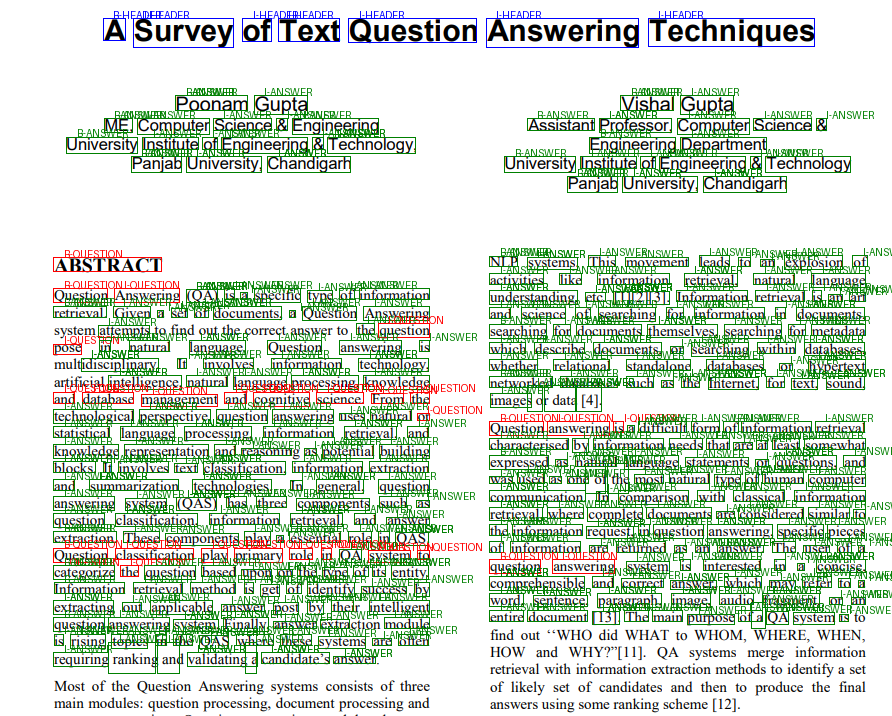

In [24]:
model_name_or_path = "aparnajjn/layoutlm-impira-funsd"
processor = AutoProcessor.from_pretrained(model_name_or_path)
model = LayoutLMForTokenClassification.from_pretrained(model_name_or_path)

def run_inference(path, model=model, processor=processor, output_image=True):

    image = Image.open(path).convert("RGB")
    encoding = processor(image, return_tensors="pt", padding="max_length", truncation=True)
    del encoding["image"]

    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels


run_inference("/content/drive/MyDrive/q1.png")

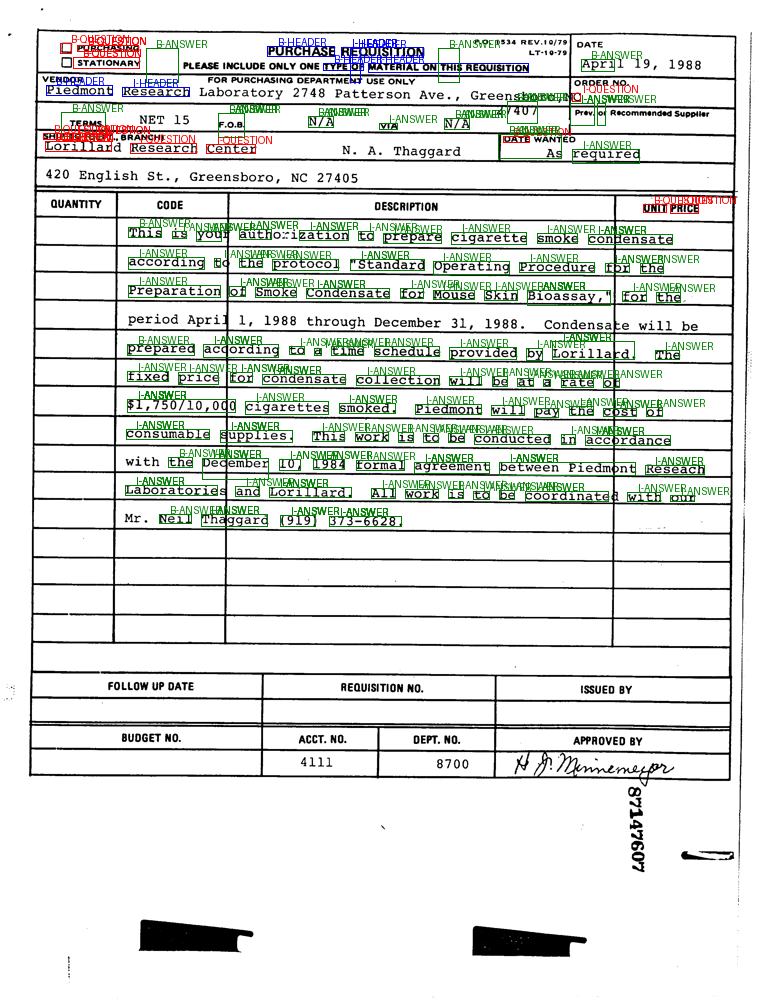

In [25]:
run_inference(dataset["test"][40]["image_path"])

In [26]:
def get_answer_2(image_path, question):
    model_name_or_path = "aparnajjn/layoutlm-impira-funsd"
    processor = AutoProcessor.from_pretrained(model_name_or_path)
    model = LayoutLMForTokenClassification.from_pretrained(model_name_or_path)

    if image_path.startswith("http"):
        response = requests.get(image_path, stream=True)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_path).convert("RGB")

    encoding = processor(image, text=question, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
    if "image" in encoding:
        del encoding["image"]
    encoding['token_type_ids'] = encoding['token_type_ids'].clamp(0, model.config.type_vocab_size - 1)

    with torch.no_grad():
        outputs = model(**encoding)

    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    labels = [model.config.id2label[p] for p in predictions]
    tokens = processor.tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    answer_tokens = []
    in_ans = False
    for t, l in zip(tokens, labels):
        if l == "B-ANSWER":
            in_ans = True
            answer_tokens.append(t)
        elif l == "I-ANSWER" and in_ans:
            answer_tokens.append(t)
        elif in_ans:
            break

    answer = processor.tokenizer.decode(processor.tokenizer.convert_tokens_to_ids(answer_tokens), skip_special_tokens=True)
    return answer

In [20]:
get_answer_2("/content/drive/MyDrive/q1.png",
    "What is the header?")

'a survey of text question answering techniques poonam gupta me, computer science & engineering university institute of engineering & technology, panjab university, chandigarh abstract question answering ( qa ) is a specific type of information retrieval. given a set of documents, a question answering pose in natural language. question answering is ‘ disciplinary. it involves information technology, intelligence, natural language processing, knowledge and database management and cognitive science. from the technological perspective, question answering uses natural or statistical language processing, information retrieval, and knowledge representation and reasoning as potential building blocks. it involves text classification, information extraction and summarization technologies. in general, question answering system ( qas ) has three components such as question classification, information retrieval, and answer extraction. these components play a essential role in qas. question classif

In [27]:
get_answer_2("/content/drive/MyDrive/q1.png",
    "Who is the author?")

'poonam gupta me, computer science & engineering university institute of engineering & technology, panjab university, chandigarh'

In [28]:
get_answer_2("https://templates.invoicehome.com/invoice-template-us-neat-750px.png",
    "What is the invoice number?")

'bill'

In [29]:
get_answer_2("/content/drive/MyDrive/q1.png",
    "What is the abstract?")

'poonam gupta me, computer science & engineering university institute of engineering & technology, panjab university, chandigarh'